In [1]:
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import pickle

from sklearn.metrics import confusion_matrix,f1_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

/Users/shunling/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# load data
df = pd.read_csv('Processed_data/all_data.csv',index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 744870 entries, 0 to 744869
Data columns (total 13 columns):
claim_id        744870 non-null float64
enrollee_id     744870 non-null float64
provider_id     744870 non-null float64
hmo_id          744870 non-null float64
care_id         744870 non-null float64
diagnosis_id    744861 non-null float64
qty             744870 non-null float64
amount          744870 non-null float64
unit_price      744870 non-null float64
tariffs         668049 non-null float64
created_at      744870 non-null object
vetted_at       744870 non-null object
label           744870 non-null int64
dtypes: float64(10), int64(1), object(2)
memory usage: 79.6+ MB


## create month feature for claim created and vetted date

In [3]:
# check data format
df.iloc[0].created_at[5:7],df.iloc[0].created_at

('03', '2018-03-12 14:53:46')

In [4]:
df['create_m'] = df.created_at.apply(lambda x: x[5:7])
df['vetted_m'] = df.vetted_at.apply(lambda x: x[5:7])

## create feature for enrollee_id by cummulated claim number and amount

In [5]:
a = df.sort_values(by='created_at')[['claim_id','enrollee_id','created_at']]

In [6]:
a.head()

,claim_id,enrollee_id,created_at
0,10.0,89.0,2018-03-12 14:53:46
1,11.0,89.0,2018-03-13 14:50:39
2,13.0,74.0,2018-03-16 10:28:53
3,13.0,74.0,2018-03-16 10:28:53
4,13.0,74.0,2018-03-16 10:28:53


In [7]:
a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 744870 entries, 0 to 744869
Data columns (total 3 columns):
claim_id       744870 non-null float64
enrollee_id    744870 non-null float64
created_at     744870 non-null object
dtypes: float64(2), object(1)
memory usage: 22.7+ MB


In [8]:
df['enrollee_cum_claim_count'] = a.groupby(['enrollee_id']).cumcount()+1

In [9]:
df.head()

,claim_id,enrollee_id,provider_id,hmo_id,care_id,diagnosis_id,qty,amount,unit_price,tariffs,created_at,vetted_at,label,create_m,vetted_m,enrollee_cum_claim_count
0,10.0,89.0,1.0,1.0,586.0,9.0,6.0,1816.08,302.68,302.68,2018-03-12 14:53:46,2018-05-21 10:05:30,0,03,05,1
1,11.0,89.0,1.0,1.0,586.0,15925.0,6.0,1816.08,302.68,302.68,2018-03-13 14:50:39,2018-05-21 10:07:19,0,03,05,2
2,13.0,74.0,1.0,1.0,434.0,4342.0,5.0,115.00,23.00,23.00,2018-03-16 10:28:53,2018-05-21 10:09:30,0,03,05,1
3,13.0,74.0,1.0,1.0,1102.0,4342.0,10.0,1265.00,126.50,126.50,2018-03-16 10:28:53,2018-05-21 10:09:30,0,03,05,2
4,13.0,74.0,1.0,1.0,299.0,4342.0,15.0,138.00,9.20,9.20,2018-03-16 10:28:53,2018-05-21 10:09:30,0,03,05,3


In [10]:
df['enrollee_cum_claim_amount'] = df.groupby(['enrollee_id'])['amount'].cumsum()

In [11]:
df.head()


,claim_id,enrollee_id,provider_id,hmo_id,care_id,diagnosis_id,qty,amount,unit_price,tariffs,created_at,vetted_at,label,create_m,vetted_m,enrollee_cum_claim_count,enrollee_cum_claim_amount
0,10.0,89.0,1.0,1.0,586.0,9.0,6.0,1816.08,302.68,302.68,2018-03-12 14:53:46,2018-05-21 10:05:30,0,03,05,1,1816.08
1,11.0,89.0,1.0,1.0,586.0,15925.0,6.0,1816.08,302.68,302.68,2018-03-13 14:50:39,2018-05-21 10:07:19,0,03,05,2,3632.16
2,13.0,74.0,1.0,1.0,434.0,4342.0,5.0,115.00,23.00,23.00,2018-03-16 10:28:53,2018-05-21 10:09:30,0,03,05,1,115.00
3,13.0,74.0,1.0,1.0,1102.0,4342.0,10.0,1265.00,126.50,126.50,2018-03-16 10:28:53,2018-05-21 10:09:30,0,03,05,2,1380.00
4,13.0,74.0,1.0,1.0,299.0,4342.0,15.0,138.00,9.20,9.20,2018-03-16 10:28:53,2018-05-21 10:09:30,0,03,05,3,1518.00


In [12]:
df_engineered = df[['claim_id','enrollee_id','enrollee_cum_claim_count','enrollee_cum_claim_amount','provider_id',\
                   'hmo_id','care_id','diagnosis_id','qty','amount','unit_price','tariffs','create_m','vetted_m','label']]

In [5]:
#df_engineered.to_csv('Processed_data/feature_engineered.csv')
#df_engineered = pd.read_csv('Processed_data/feature_engineered.csv',index_col=0)

In [6]:
# training and testing data
X = df_engineered.drop(columns=['claim_id','enrollee_id','vetted_m','label'])
y = df_engineered.label

In [7]:
X.head()

,enrollee_cum_claim_count,enrollee_cum_claim_amount,provider_id,hmo_id,care_id,diagnosis_id,qty,amount,unit_price,tariffs,create_m
0,1,1816.08,1.0,1.0,586.0,9.0,6.0,1816.08,302.68,302.68,3
1,2,3632.16,1.0,1.0,586.0,15925.0,6.0,1816.08,302.68,302.68,3
2,1,115.00,1.0,1.0,434.0,4342.0,5.0,115.00,23.00,23.00,3
3,2,1380.00,1.0,1.0,1102.0,4342.0,10.0,1265.00,126.50,126.50,3
4,3,1518.00,1.0,1.0,299.0,4342.0,15.0,138.00,9.20,9.20,3


In [74]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2,random_state=2)

In [9]:
def init_scores():
    
    scores = {}
    scores['f1_socre'] = []
    scores['precision'] = []
    scores['recall'] = []
    scores['FPR'] = []
    scores['specificity'] = []
    scores['roc_auc'] = []
    
    return scores


def evaluation(ytest,Xtest,cls):

    scores = init_scores()
    ypred = cls.predict(Xtest)
    C = confusion_matrix(ytest,ypred)
    TN = C[0][0]
    FN = C[1][0]
    TP = C[1][1]
    FP = C[0][1]

    print('f1_socre: {:0.3f}'.format(f1_score(ytest,ypred)))
    scores['f1_socre'].append(f1_score(ytest,ypred))
    print('precision: {:0.3f}'.format(TP/(TP+FP)))
    scores['precision'].append(TP/(TP+FP))
    print('recall/sensitivity(true positive rate): {:0.3f}'.format(TP/(TP+FN)))
    scores['recall'].append(TP/(TP+FN))
    print('false positive rate (FPR): {:0.3f}'.format(1-(TN/(TN+FP)))) # 1 - specificity
    scores['FPR'].append(1-(TN/(TN+FP)))
    print('spcificity(true negative rate): {:0.3f}'.format(TN/(TN+FP)))
    scores['specificity'].append(TN/(TN+FP))
    print('ROC_AUC_score: {:0.3f}'.format(roc_auc_score(ytest,ypred)))
    scores['roc_auc'].append(roc_auc_score(ytest,ypred))
    
    return scores
    
def cv(Xtrain,ytrain,model):

    models = []
    kf = KFold(n_splits=4)
    print(model)
    n = 0
    for train_index, test_index in kf.split(Xtrain):
        print('cross_validate_run: {}'.format(n))
        Xtr, Xte = Xtrain[train_index], Xtrain[test_index]
        ytr, yte = ytrain[train_index], ytrain[test_index]
        cls = model.fit(Xtr, ytr) 
        models.append(cls)
        scores = evaluation(yte,Xte,cls)
        n += 1
    
    print('\n mean scores +/- sd: \n')
    for k in scores:
        print('{} : {:0.3f} +/- {:0.3f}'.format(k, np.array(scores[k]).mean(),  np.array(scores[k]).std()))
        
    
    return models, scores

In [10]:
# explore depth info
allmodels = []
allscores = []
for d in [10,15,20,25,30]:
    print("maximum depth: {}".format(d))
    lgb = LGBMClassifier(boosting_type='gbdt', num_leaves=min(2**d-1,2000), max_depth=d, learning_rate=0.1, \
                       n_estimators=300, subsample_for_bin=200000, objective=None, class_weight={1:25}, \
                       min_split_gain=0.0, min_child_weight=1, min_child_samples=1, subsample=1.0, \
                       subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=1, \
                       random_state=None, n_jobs=4, silent=True, importance_type='split',bagging_fraction=0.1,bagging_freq=10)
    

    lgb_models, lgb_scores = cv(Xtrain.values,ytrain.values,lgb)
    allmodels.append(lgb_models)
    allscores.append(lgb_scores)

maximum depth: 10
LGBMClassifier(bagging_fraction=0.1, bagging_freq=10, boosting_type='gbdt',
               class_weight={1: 25}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=10,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=1023, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
cross_validate_run: 0
f1_socre: 0.347
precision: 0.233
recall/sensitivity(true positive rate): 0.681
false positive rate (FPR): 0.099
spcificity(true negative rate): 0.901
ROC_AUC_score: 0.791
cross_validate_run: 1
f1_socre: 0.356
precision: 0.241
recall/sensitivity(true positive rate): 0.683
false positive rate (FPR): 0.096
spcificity(true negative rate): 0.904
ROC_AUC_score: 0.793
cross_validate_run: 2
f1_socre: 0.358
precision: 0.247
recall/sensitivity(true positiv

In [11]:
for d in [9,11,13]:
    print("maximum depth: {}".format(d))
    lgb = LGBMClassifier(boosting_type='gbdt', num_leaves=min(2**d-1,2000), max_depth=d, learning_rate=0.1, \
                       n_estimators=300, subsample_for_bin=200000, objective=None, class_weight={1:25}, \
                       min_split_gain=0.0, min_child_weight=1, min_child_samples=1, subsample=1.0, \
                       subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=1, \
                       random_state=None, n_jobs=4, silent=True, importance_type='split',bagging_fraction=0.1,bagging_freq=10)
    

    lgb_models, lgb_scores = cv(Xtrain.values,ytrain.values,lgb)
    allmodels.append(lgb_models)
    allscores.append(lgb_scores)

maximum depth: 9
LGBMClassifier(bagging_fraction=0.1, bagging_freq=10, boosting_type='gbdt',
               class_weight={1: 25}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=9,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=511, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
cross_validate_run: 0
f1_socre: 0.300
precision: 0.190
recall/sensitivity(true positive rate): 0.717
false positive rate (FPR): 0.134
spcificity(true negative rate): 0.866
ROC_AUC_score: 0.791
cross_validate_run: 1
f1_socre: 0.318
precision: 0.207
recall/sensitivity(true positive rate): 0.688
false positive rate (FPR): 0.118
spcificity(true negative rate): 0.882
ROC_AUC_score: 0.785
cross_validate_run: 2
f1_socre: 0.303
precision: 0.193
recall/sensitivity(true positive r

In [12]:
for d in [5,6,7]:
    print("maximum depth: {}".format(d))
    lgb = LGBMClassifier(boosting_type='gbdt', num_leaves=min(2**d-1,2000), max_depth=d, learning_rate=0.1, \
                       n_estimators=300, subsample_for_bin=200000, objective=None, class_weight={1:25}, \
                       min_split_gain=0.0, min_child_weight=1, min_child_samples=1, subsample=1.0, \
                       subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=1, \
                       random_state=None, n_jobs=4, silent=True, importance_type='split',bagging_fraction=0.1,bagging_freq=10)
    

    lgb_models, lgb_scores = cv(Xtrain.values,ytrain.values,lgb)
    allmodels.append(lgb_models)
    allscores.append(lgb_scores)

maximum depth: 5
LGBMClassifier(bagging_fraction=0.1, bagging_freq=10, boosting_type='gbdt',
               class_weight={1: 25}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=5,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
cross_validate_run: 0
f1_socre: 0.222
precision: 0.130
recall/sensitivity(true positive rate): 0.753
false positive rate (FPR): 0.221
spcificity(true negative rate): 0.779
ROC_AUC_score: 0.766
cross_validate_run: 1
f1_socre: 0.232
precision: 0.137
recall/sensitivity(true positive rate): 0.763
false positive rate (FPR): 0.215
spcificity(true negative rate): 0.785
ROC_AUC_score: 0.774
cross_validate_run: 2
f1_socre: 0.222
precision: 0.130
recall/sensitivity(true positive ra

In [13]:
name = "models/lgb_t"
d = [10,15,20,25,30,9,11,13,5,6,7]
for n, model in zip(d,allmodels):
    pickle.dump(model,open(name+str(n)+".dat", "wb"))

In [15]:
# depth 9 is best
tree9 = LGBMClassifier(bagging_fraction=0.1, bagging_freq=10, boosting_type='gbdt',
               class_weight={1: 25}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=9,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=511, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [21]:
def plot_roc_curves(curves,colors,labels):
    plt.plot([0,0.5,1],[0,0.5,1], linestyle='--', color = 'black') # default classification bound
    
    for i in range(len(curves)):
        fpr, tpr, _ = curves[i]
        plt.plot(fpr,tpr,color=colors[i],linewidth=2,label=labels[i])
    
    plt.xlabel('False Positive Rate',fontsize=20)
    plt.ylabel('True Positive Rate',fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)

    plt.show()

In [22]:
# plot importance
import lightgbm

def feature_importance(model,columns):
    # Plot importance for beset model: model_mse
    fig, ax = plt.subplots(figsize=(15,5))

    g1 = lightgbm.plot_importance(model,ax=ax,grid=False)

    oldy = g1.yaxis.get_majorticklabels()
    feature_dict = dict(zip(['Column_'+str(i) for i in range(len(columns))], columns))
    newy = [feature_dict[y._text] for y in oldy]
    g1.set_yticklabels(newy,rotation=0,fontsize=18)

    #fig.savefig('feature_importance.jpg')
    plt.title('Feature Importance',fontsize=26)
    plt.xlabel('Feature importance',fontsize = 24)
    plt.ylabel('Features', fontsize = 24)
    plt.show()

In [19]:
# roc_curve
depth5 = roc_curve(ytest,allmodels[8][0].predict_proba(Xtest.values)[:,1])
depth9 = roc_curve(ytest,allmodels[5][0].predict_proba(Xtest.values)[:,1])
depth11 = roc_curve(ytest,allmodels[6][0].predict_proba(Xtest.values)[:,1])


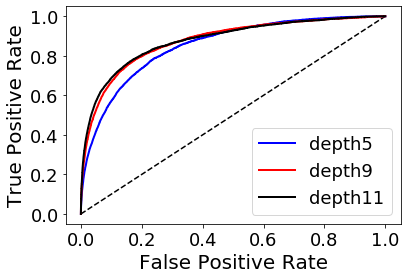

In [24]:
plot_roc_curves([depth5, depth9, depth11],['b','r','black'],['depth5','depth9','depth11'])

In [29]:
# compare with nb and xgb
from sklearn.naive_bayes import ComplementNB
from xgboost import XGBClassifier


In [34]:
nb = ComplementNB()
xbg = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=25, seed=None,
              silent=None, subsample=1, verbosity=1)


In [35]:
cv(Xtrain.values,ytrain.values,xbg)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=25, seed=None,
              silent=None, subsample=1, verbosity=1)
cross_validate_run: 0
f1_socre: 0.202
precision: 0.116
recall/sensitivity(true positive rate): 0.778
false positive rate (FPR): 0.261
spcificity(true negative rate): 0.739
ROC_AUC_score: 0.758
cross_validate_run: 1
f1_socre: 0.206
precision: 0.119
recall/sensitivity(true positive rate): 0.779
false positive rate (FPR): 0.259
spcificity(true negative rate): 0.741
ROC_AUC_score: 0.760
cross_validate_run: 2
f1_socre: 0.205
precision: 0.118
recall/sensitivity(true positive rate): 0.785
false positive rate (FPR): 0.262
spcificit

([XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0,
                learning_rate=0.1, max_delta_step=0, max_depth=5,
                min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
                nthread=None, objective='binary:logistic', random_state=0,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=25, seed=None,
                silent=None, subsample=1, verbosity=1),
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0,
                learning_rate=0.1, max_delta_step=0, max_depth=5,
                min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
                nthread=None, objective='binary:logistic', random_state=0,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=25, seed=None,
                silent=None, subsample=1, verbosity=1),
  XGBClassifier(base_score=0

In [38]:

nb.fit(Xtrain.fillna(0).values, ytrain.values)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

In [40]:
nbs = roc_curve(ytest,nb.predict_proba(Xtest.fillna(0).values)[:,1])
xbgs = roc_curve(ytest,xbg.predict_proba(Xtest.values)[:,1])
lgbs = roc_curve(ytest,allmodels[8][0].predict_proba(Xtest.values)[:,1])

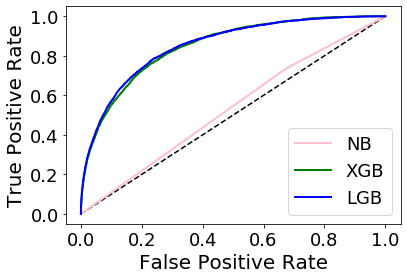

In [41]:
plot_roc_curves([nbs, xbgs, lgbs],['pink','green','blue'],['NB','XGB','LGB'])

In [42]:
pickle.dump(nb,open("models/nb.dat","wb"))
pickle.dump(xbg,open("models/xbg.dat","wb"))
pickle.dump(lgb,open("models/lgb.dat","wb"))

# upsampling training sample

In [75]:
Xyt = Xtrain.copy()
Xyt['y'] = ytrain

class0t = Xyt.loc[Xyt.y == 0]
class1t = Xyt.loc[Xyt.y == 1]

class1t = class1t.sample(n=class0t.shape[0],replace=True,random_state=0)
Xyt = pd.concat([class0t,class1t])
yt = Xyt['y'] # ytrain
Xt = Xyt.drop(columns=['y']) # Xtrain


In [46]:
model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=10, boosting_type='gbdt',
               class_weight={1: 1}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=9,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=500, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [47]:
model.fit(Xt.values,yt.values)

LGBMClassifier(bagging_fraction=0.1, bagging_freq=10, boosting_type='gbdt',
               class_weight={1: 1}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=9,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=500, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [48]:
evaluation(yt,Xt,model)
testscores = evaluation(ytest,Xtest,model)

f1_socre: 0.944
precision: 0.925
recall/sensitivity(true positive rate): 0.965
false positive rate (FPR): 0.078
spcificity(true negative rate): 0.922
ROC_AUC_score: 0.943
f1_socre: 0.446
precision: 0.304
recall/sensitivity(true positive rate): 0.841
false positive rate (FPR): 0.085
spcificity(true negative rate): 0.915
ROC_AUC_score: 0.878


In [52]:
# over-fitting observed, re-tune parameters.
param = [3,4,5,6]
for p in param:
    model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=10, boosting_type='gbdt',
               class_weight={1: 1}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=p,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=500, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
    model.fit(Xt.values,yt.values)
    print('training score')
    evaluation(yt,Xt,model)
    print('testing score')
    evaluation(ytest,Xtest,model)

training score
f1_socre: 0.758
precision: 0.759
recall/sensitivity(true positive rate): 0.758
false positive rate (FPR): 0.241
spcificity(true negative rate): 0.759
ROC_AUC_score: 0.759
testing score
f1_socre: 0.207
precision: 0.120
recall/sensitivity(true positive rate): 0.750
false positive rate (FPR): 0.242
spcificity(true negative rate): 0.758
ROC_AUC_score: 0.754
training score
f1_socre: 0.787
precision: 0.790
recall/sensitivity(true positive rate): 0.785
false positive rate (FPR): 0.209
spcificity(true negative rate): 0.791
ROC_AUC_score: 0.788
testing score
f1_socre: 0.233
precision: 0.137
recall/sensitivity(true positive rate): 0.762
false positive rate (FPR): 0.210
spcificity(true negative rate): 0.790
ROC_AUC_score: 0.776
training score
f1_socre: 0.825
precision: 0.823
recall/sensitivity(true positive rate): 0.828
false positive rate (FPR): 0.179
spcificity(true negative rate): 0.821
ROC_AUC_score: 0.825
testing score
f1_socre: 0.271
precision: 0.163
recall/sensitivity(true p

In [53]:
param = [7,8,9,10]
for p in param:
    model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=10, boosting_type='gbdt',
               class_weight={1: 1}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=p,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=500, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
    model.fit(Xt.values,yt.values)
    print('training score')
    evaluation(yt,Xt,model)
    print('testing score')
    evaluation(ytest,Xtest,model)

training score
f1_socre: 0.891
precision: 0.878
recall/sensitivity(true positive rate): 0.904
false positive rate (FPR): 0.126
spcificity(true negative rate): 0.874
ROC_AUC_score: 0.889
testing score
f1_socre: 0.348
precision: 0.220
recall/sensitivity(true positive rate): 0.831
false positive rate (FPR): 0.129
spcificity(true negative rate): 0.871
ROC_AUC_score: 0.851
training score
f1_socre: 0.921
precision: 0.904
recall/sensitivity(true positive rate): 0.938
false positive rate (FPR): 0.099
spcificity(true negative rate): 0.901
ROC_AUC_score: 0.919
testing score
f1_socre: 0.400
precision: 0.262
recall/sensitivity(true positive rate): 0.840
false positive rate (FPR): 0.104
spcificity(true negative rate): 0.896
ROC_AUC_score: 0.868
training score
f1_socre: 0.944
precision: 0.925
recall/sensitivity(true positive rate): 0.965
false positive rate (FPR): 0.078
spcificity(true negative rate): 0.922
ROC_AUC_score: 0.943
testing score
f1_socre: 0.446
precision: 0.304
recall/sensitivity(true p

In [54]:
param = [11,12,13,14]
for p in param:
    model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=10, boosting_type='gbdt',
               class_weight={1: 1}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=p,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=500, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
    model.fit(Xt.values,yt.values)
    print('training score')
    evaluation(yt,Xt,model)
    print('testing score')
    evaluation(ytest,Xtest,model)

training score
f1_socre: 0.973
precision: 0.955
recall/sensitivity(true positive rate): 0.991
false positive rate (FPR): 0.046
spcificity(true negative rate): 0.954
ROC_AUC_score: 0.973
testing score
f1_socre: 0.543
precision: 0.403
recall/sensitivity(true positive rate): 0.831
false positive rate (FPR): 0.054
spcificity(true negative rate): 0.946
ROC_AUC_score: 0.889
training score
f1_socre: 0.979
precision: 0.963
recall/sensitivity(true positive rate): 0.996
false positive rate (FPR): 0.038
spcificity(true negative rate): 0.962
ROC_AUC_score: 0.979
testing score
f1_socre: 0.577
precision: 0.443
recall/sensitivity(true positive rate): 0.826
false positive rate (FPR): 0.046
spcificity(true negative rate): 0.954
ROC_AUC_score: 0.890
training score
f1_socre: 0.983
precision: 0.968
recall/sensitivity(true positive rate): 0.998
false positive rate (FPR): 0.033
spcificity(true negative rate): 0.967
ROC_AUC_score: 0.982
testing score
f1_socre: 0.598
precision: 0.470
recall/sensitivity(true p

In [55]:
# tune other parameters
# bagging frequency
param = [1,3,5,7]
for p in param:
    model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=p, boosting_type='gbdt',
               class_weight={1: 1}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=10,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=500, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
    model.fit(Xt.values,yt.values)
    print('training score------------------')
    evaluation(yt,Xt,model)
    print('testing score...................')
    evaluation(ytest,Xtest,model)

training score------------------
f1_socre: 0.971
precision: 0.952
recall/sensitivity(true positive rate): 0.990
false positive rate (FPR): 0.050
spcificity(true negative rate): 0.950
ROC_AUC_score: 0.970
testing score...................
f1_socre: 0.537
precision: 0.394
recall/sensitivity(true positive rate): 0.842
false positive rate (FPR): 0.057
spcificity(true negative rate): 0.943
ROC_AUC_score: 0.893
training score------------------
f1_socre: 0.969
precision: 0.949
recall/sensitivity(true positive rate): 0.989
false positive rate (FPR): 0.053
spcificity(true negative rate): 0.947
ROC_AUC_score: 0.968
testing score...................
f1_socre: 0.526
precision: 0.383
recall/sensitivity(true positive rate): 0.842
false positive rate (FPR): 0.060
spcificity(true negative rate): 0.940
ROC_AUC_score: 0.891
training score------------------
f1_socre: 0.966
precision: 0.946
recall/sensitivity(true positive rate): 0.986
false positive rate (FPR): 0.056
spcificity(true negative rate): 0.944
R

In [56]:
# subsample_for_bin
param = [5000,10000,50000]
for p in param:
    model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=1, boosting_type='gbdt',
               class_weight={1: 1}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=10,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=500, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=p, subsample_freq=0)
    model.fit(Xt.values,yt.values)
    print('training score------------------')
    evaluation(yt,Xt,model)
    print('testing score...................')
    evaluation(ytest,Xtest,model)

training score------------------
f1_socre: 0.971
precision: 0.953
recall/sensitivity(true positive rate): 0.991
false positive rate (FPR): 0.049
spcificity(true negative rate): 0.951
ROC_AUC_score: 0.971
testing score...................
f1_socre: 0.540
precision: 0.398
recall/sensitivity(true positive rate): 0.840
false positive rate (FPR): 0.056
spcificity(true negative rate): 0.944
ROC_AUC_score: 0.892
training score------------------
f1_socre: 0.972
precision: 0.952
recall/sensitivity(true positive rate): 0.991
false positive rate (FPR): 0.050
spcificity(true negative rate): 0.950
ROC_AUC_score: 0.971
testing score...................
f1_socre: 0.538
precision: 0.396
recall/sensitivity(true positive rate): 0.840
false positive rate (FPR): 0.056
spcificity(true negative rate): 0.944
ROC_AUC_score: 0.892
training score------------------
f1_socre: 0.970
precision: 0.951
recall/sensitivity(true positive rate): 0.989
false positive rate (FPR): 0.051
spcificity(true negative rate): 0.949
R

In [58]:
# subsample_for_bin
param = [100000,500000]
for p in param:
    model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=1, boosting_type='gbdt',
               class_weight={1: 1}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=10,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=500, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=p, subsample_freq=0)
    model.fit(Xt.values,yt.values)
    print('training score------------------')
    evaluation(yt,Xt,model)
    print('testing score...................')
    evaluation(ytest,Xtest,model)

training score------------------
f1_socre: 0.971
precision: 0.952
recall/sensitivity(true positive rate): 0.991
false positive rate (FPR): 0.050
spcificity(true negative rate): 0.950
ROC_AUC_score: 0.970
testing score...................
f1_socre: 0.537
precision: 0.394
recall/sensitivity(true positive rate): 0.844
false positive rate (FPR): 0.057
spcificity(true negative rate): 0.943
ROC_AUC_score: 0.893
training score------------------
f1_socre: 0.971
precision: 0.953
recall/sensitivity(true positive rate): 0.991
false positive rate (FPR): 0.049
spcificity(true negative rate): 0.951
ROC_AUC_score: 0.971
testing score...................
f1_socre: 0.541
precision: 0.399
recall/sensitivity(true positive rate): 0.843
false positive rate (FPR): 0.056
spcificity(true negative rate): 0.944
ROC_AUC_score: 0.893


In [59]:
# num_leaves
param = [100,300,1000,3000]
for p in param:
    model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=1, boosting_type='gbdt',
               class_weight={1: 1}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=10,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=p, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
    model.fit(Xt.values,yt.values)
    print('training score------------------')
    evaluation(yt,Xt,model)
    print('testing score...................')
    evaluation(ytest,Xtest,model)

training score------------------
f1_socre: 0.924
precision: 0.903
recall/sensitivity(true positive rate): 0.946
false positive rate (FPR): 0.101
spcificity(true negative rate): 0.899
ROC_AUC_score: 0.922
testing score...................
f1_socre: 0.399
precision: 0.261
recall/sensitivity(true positive rate): 0.848
false positive rate (FPR): 0.106
spcificity(true negative rate): 0.894
ROC_AUC_score: 0.871
training score------------------
f1_socre: 0.967
precision: 0.947
recall/sensitivity(true positive rate): 0.988
false positive rate (FPR): 0.056
spcificity(true negative rate): 0.944
ROC_AUC_score: 0.966
testing score...................
f1_socre: 0.516
precision: 0.371
recall/sensitivity(true positive rate): 0.842
false positive rate (FPR): 0.063
spcificity(true negative rate): 0.937
ROC_AUC_score: 0.890
training score------------------
f1_socre: 0.971
precision: 0.953
recall/sensitivity(true positive rate): 0.991
false positive rate (FPR): 0.049
spcificity(true negative rate): 0.951
R

In [61]:
# colsample_bytree
param = [0.2,0.4,0.6,0.8]
for p in param:
    model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=1, boosting_type='gbdt',
               class_weight={1: 1}, colsample_bytree=p,
               importance_type='split', learning_rate=0.1, max_depth=10,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=1000, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
    model.fit(Xt.values,yt.values)
    print('training score------------------')
    evaluation(yt,Xt,model)
    print('testing score...................')
    evaluation(ytest,Xtest,model)

training score------------------
f1_socre: 0.911
precision: 0.891
recall/sensitivity(true positive rate): 0.933
false positive rate (FPR): 0.115
spcificity(true negative rate): 0.885
ROC_AUC_score: 0.909
testing score...................
f1_socre: 0.367
precision: 0.236
recall/sensitivity(true positive rate): 0.833
false positive rate (FPR): 0.119
spcificity(true negative rate): 0.881
ROC_AUC_score: 0.857
training score------------------
f1_socre: 0.957
precision: 0.936
recall/sensitivity(true positive rate): 0.979
false positive rate (FPR): 0.067
spcificity(true negative rate): 0.933
ROC_AUC_score: 0.956
testing score...................
f1_socre: 0.483
precision: 0.338
recall/sensitivity(true positive rate): 0.848
false positive rate (FPR): 0.073
spcificity(true negative rate): 0.927
ROC_AUC_score: 0.888
training score------------------
f1_socre: 0.967
precision: 0.948
recall/sensitivity(true positive rate): 0.988
false positive rate (FPR): 0.054
spcificity(true negative rate): 0.946
R

In [62]:
# feature_fraction
param = [0.2,0.4,0.6,0.8]
for p in param:
    model = LGBMClassifier(feature_fraction=p,bagging_fraction=0.1, bagging_freq=1, boosting_type='gbdt',
               class_weight={1: 1}, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.1, max_depth=10,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=1000, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
    model.fit(Xt.values,yt.values)
    print('training score------------------')
    evaluation(yt,Xt,model)
    print('testing score...................')
    evaluation(ytest,Xtest,model)


training score------------------
f1_socre: 0.911
precision: 0.891
recall/sensitivity(true positive rate): 0.933
false positive rate (FPR): 0.115
spcificity(true negative rate): 0.885
ROC_AUC_score: 0.909
testing score...................
f1_socre: 0.367
precision: 0.236
recall/sensitivity(true positive rate): 0.833
false positive rate (FPR): 0.119
spcificity(true negative rate): 0.881
ROC_AUC_score: 0.857
training score------------------
f1_socre: 0.957
precision: 0.936
recall/sensitivity(true positive rate): 0.979
false positive rate (FPR): 0.067
spcificity(true negative rate): 0.933
ROC_AUC_score: 0.956
testing score...................
f1_socre: 0.483
precision: 0.338
recall/sensitivity(true positive rate): 0.848
false positive rate (FPR): 0.073
spcificity(true negative rate): 0.927
ROC_AUC_score: 0.888
training score------------------
f1_socre: 0.967
precision: 0.948
recall/sensitivity(true positive rate): 0.988
false positive rate (FPR): 0.054
spcificity(true negative rate): 0.946
R

In [68]:
# further 
param = [10,15,20]
for p in param:
    model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=3, boosting_type='gbdt',
               class_weight={1: 1}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=p,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=1000, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
    model.fit(Xt.values,yt.values)
    print('training score------------------')
    evaluation(yt,Xt,model)
    print('testing score...................')
    evaluation(ytest,Xtest,model)


training score------------------
f1_socre: 0.969
precision: 0.950
recall/sensitivity(true positive rate): 0.988
false positive rate (FPR): 0.052
spcificity(true negative rate): 0.948
ROC_AUC_score: 0.968
testing score...................
f1_socre: 0.525
precision: 0.382
recall/sensitivity(true positive rate): 0.839
false positive rate (FPR): 0.060
spcificity(true negative rate): 0.940
ROC_AUC_score: 0.890
training score------------------
f1_socre: 0.993
precision: 0.986
recall/sensitivity(true positive rate): 1.000
false positive rate (FPR): 0.014
spcificity(true negative rate): 0.986
ROC_AUC_score: 0.993
testing score...................
f1_socre: 0.686
precision: 0.602
recall/sensitivity(true positive rate): 0.797
false positive rate (FPR): 0.023
spcificity(true negative rate): 0.977
ROC_AUC_score: 0.887
training score------------------
f1_socre: 0.995
precision: 0.990
recall/sensitivity(true positive rate): 1.000
false positive rate (FPR): 0.010
spcificity(true negative rate): 0.990
R

In [69]:
# check depth again
param = [10,15,20]
for p in param:
    model = LGBMClassifier(feature_fraction=0.8,bagging_fraction=0.1, bagging_freq=1, boosting_type='gbdt',
               class_weight={1: 1}, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.1, max_depth=p,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=1000, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
    model.fit(Xt.values,yt.values)
    print('training score------------------')
    evaluation(yt,Xt,model)
    print('testing score...................')
    evaluation(ytest,Xtest,model)


training score------------------
f1_socre: 0.970
precision: 0.951
recall/sensitivity(true positive rate): 0.990
false positive rate (FPR): 0.051
spcificity(true negative rate): 0.949
ROC_AUC_score: 0.970
testing score...................
f1_socre: 0.536
precision: 0.392
recall/sensitivity(true positive rate): 0.846
false positive rate (FPR): 0.057
spcificity(true negative rate): 0.943
ROC_AUC_score: 0.894
training score------------------
f1_socre: 0.993
precision: 0.986
recall/sensitivity(true positive rate): 1.000
false positive rate (FPR): 0.014
spcificity(true negative rate): 0.986
ROC_AUC_score: 0.993
testing score...................
f1_socre: 0.695
precision: 0.610
recall/sensitivity(true positive rate): 0.807
false positive rate (FPR): 0.023
spcificity(true negative rate): 0.977
ROC_AUC_score: 0.892
training score------------------
f1_socre: 0.995
precision: 0.990
recall/sensitivity(true positive rate): 1.000
false positive rate (FPR): 0.010
spcificity(true negative rate): 0.990
R

In [77]:
# first optimized model

model = LGBMClassifier(categorical_features="2,3,4,5", feature_fraction=0.8, boosting_type='gbdt',
               class_weight={1: 1}, colsample_bytree=0.8,bagging_fraction=0.1, bagging_freq=1,
               importance_type='split', learning_rate=0.1, max_depth=20,metric='roc_auc',
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=1000, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=1)
model.fit(Xt.values,yt.values)
print('training score------------------')
evaluation(yt,Xt,model)
print('testing score...................')
evaluation(ytest,Xtest,model)


training score------------------
f1_socre: 0.995
precision: 0.990
recall/sensitivity(true positive rate): 1.000
false positive rate (FPR): 0.010
spcificity(true negative rate): 0.990
ROC_AUC_score: 0.995
testing score...................
f1_socre: 0.723
precision: 0.660
recall/sensitivity(true positive rate): 0.800
false positive rate (FPR): 0.018
spcificity(true negative rate): 0.982
ROC_AUC_score: 0.891


{'f1_socre': [0.7234566114207136],
 'precision': [0.6604995374653099],
 'recall': [0.79968],
 'FPR': [0.017999775791037287],
 'specificity': [0.9820002242089627],
 'roc_auc': [0.8908401121044813]}

In [79]:
pickle.dump(model,open("models/opti1.dat","wb"))

In [80]:
# second optimized model
model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=3, boosting_type='gbdt',
               class_weight={1: 200}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=1000, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

model.fit(Xt.values,yt.values)
print('training score------------------')
evaluation(yt,Xt,model)
print('testing score...................')
evaluation(ytest,Xtest,model)

training score------------------
f1_socre: 0.970
precision: 0.942
recall/sensitivity(true positive rate): 1.000
false positive rate (FPR): 0.062
spcificity(true negative rate): 0.938
ROC_AUC_score: 0.969
testing score...................
f1_socre: 0.488
precision: 0.334
recall/sensitivity(true positive rate): 0.910
false positive rate (FPR): 0.080
spcificity(true negative rate): 0.920
ROC_AUC_score: 0.915


{'f1_socre': [0.4884329799562213],
 'precision': [0.33374391459909675],
 'recall': [0.9104],
 'FPR': [0.0795871752473305],
 'specificity': [0.9204128247526695],
 'roc_auc': [0.9154064123763348]}

In [81]:
pickle.dump(model,open("models/opti2.dat","wb"))

In [82]:
# third optimized model
model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=3, boosting_type='gbdt',
               class_weight={1: 1}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=1000, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

model.fit(Xt.values,yt.values)
print('training score------------------')
evaluation(yt,Xt,model)
print('testing score...................')
evaluation(ytest,Xtest,model)

training score------------------
f1_socre: 0.993
precision: 0.986
recall/sensitivity(true positive rate): 1.000
false positive rate (FPR): 0.014
spcificity(true negative rate): 0.986
ROC_AUC_score: 0.993
testing score...................
f1_socre: 0.692
precision: 0.611
recall/sensitivity(true positive rate): 0.798
false positive rate (FPR): 0.022
spcificity(true negative rate): 0.978
ROC_AUC_score: 0.888


{'f1_socre': [0.6918221544010542],
 'precision': [0.6106281376270356],
 'recall': [0.79792],
 'FPR': [0.022280765673607816],
 'specificity': [0.9777192343263922],
 'roc_auc': [0.887819617163196]}

In [ ]:
# third optimized model
model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=1, boosting_type='gbdt',
               class_weight={1: 1}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=1000, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

model.fit(Xt.values,yt.values)
print('training score------------------')
evaluation(yt,Xt,model)
print('testing score...................')
evaluation(ytest,Xtest,model)

### Further validating feature importance

In [36]:
# drop diagnosis
# train test split
X1 = X.drop(columns=['diagnosis_id'])
X1train,X1test,y1train,y1test = train_test_split(X1,yup,test_size = 0.2, random_state=42)

In [37]:
# model
best_model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=10, boosting_type='gbdt',
               class_weight={1: 2}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=300, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [38]:
# fit model
best_model.fit(X1train.values,y1train.values)

LGBMClassifier(bagging_fraction=0.1, bagging_freq=10, boosting_type='gbdt',
               class_weight={1: 2}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=300, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [39]:
# test score validation
test1 = evaluation(y1test.values,X1test.values,best_model)

f1_socre: 0.957
precision: 0.921
recall/sensitivity(true positive rate): 0.997
false positive rate (FPR): 0.086
spcificity(true negative rate): 0.914
ROC_AUC_score: 0.955


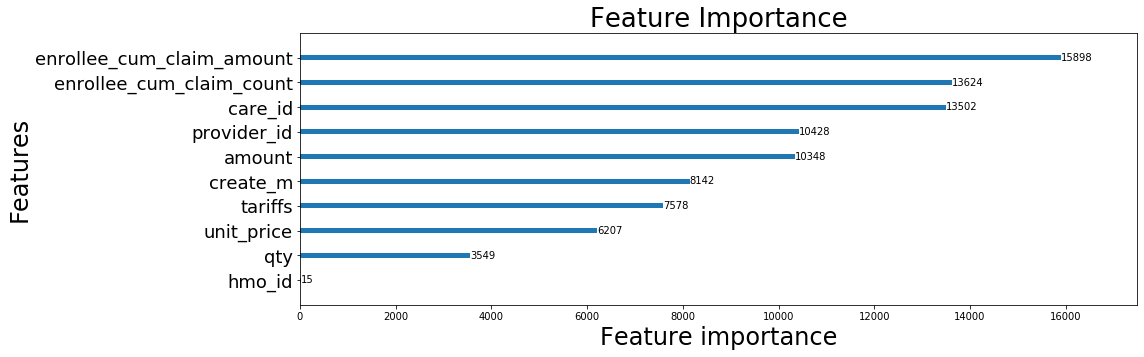

In [40]:
# plot feature importance
feature_importance(best_model,X1train.columns)

In [41]:
# roc_curve
nodiag = roc_curve(y1test,best_model.predict_proba(X1test.values)[:,1])

In [42]:
# save model
pickle.dump(best_model,open("Models/lightgbm/lgb_noDiag.dat", "wb"))

f1_socre: 0.956
precision: 0.917
recall/sensitivity(true positive rate): 0.998
false positive rate (FPR): 0.090
spcificity(true negative rate): 0.910
ROC_AUC_score: 0.954


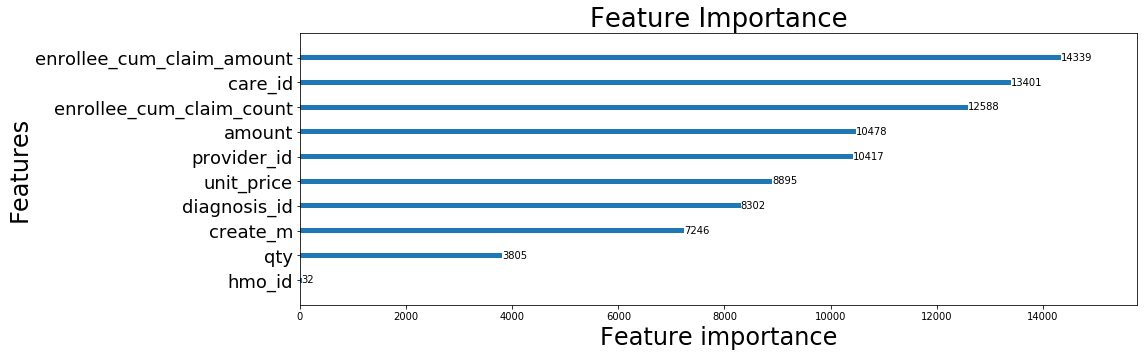

In [43]:
# drop tariffs
X2 = Xup.drop(columns=['tariffs'])
X2train,X2test,y2train,y2test = train_test_split(X2,yup,test_size = 0.2, random_state=42)
model2 = best_model
model2.fit(X2train.values,y2train.values)
test2 = evaluation(y2test.values,X2test.values,model2)
feature_importance(model2,X2train.columns)

In [44]:
# roc_curve and save model
notarif = roc_curve(y2test,model2.predict_proba(X2test.values)[:,1])
pickle.dump(model2,open("Models/lightgbm/lgb_noTariff.dat", "wb"))

In [45]:
# drop enrollee
X3 = Xup.drop(columns=['enrollee_cum_claim_count','enrollee_cum_claim_amount'])
X3train,X3test,y3train,y3test = train_test_split(X3,yup,test_size = 0.2, random_state=42)


f1_socre: 0.936
precision: 0.885
recall/sensitivity(true positive rate): 0.992
false positive rate (FPR): 0.129
spcificity(true negative rate): 0.871
ROC_AUC_score: 0.931


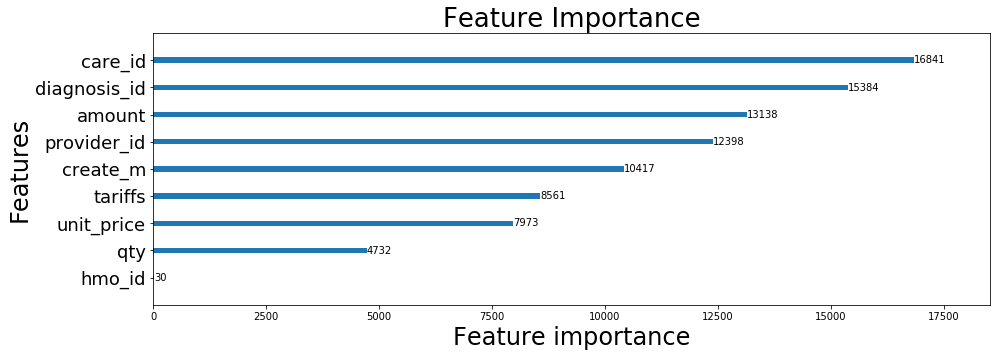

In [46]:
model3 = best_model
model3.fit(X3train.values,y3train.values)
test3 = evaluation(y3test.values,X3test.values,model3)
feature_importance(model3,X3train.columns)
# roc_curve and save model
noenro = roc_curve(y3test,model3.predict_proba(X3test.values)[:,1])
pickle.dump(model3,open("Models/lightgbm/lgb_noEnrollee.dat", "wb"))

f1_socre: 0.917
precision: 0.857
recall/sensitivity(true positive rate): 0.986
false positive rate (FPR): 0.165
spcificity(true negative rate): 0.835
ROC_AUC_score: 0.910


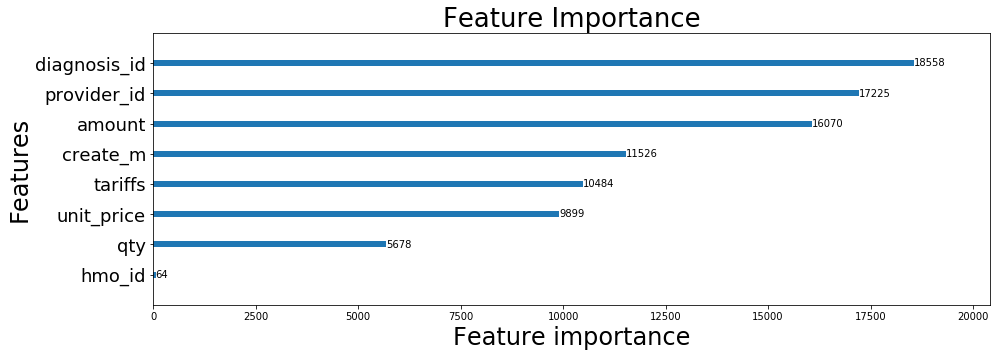

In [47]:
# drop enrollee_care

X5 = Xup.drop(columns=['enrollee_cum_claim_count','enrollee_cum_claim_amount','care_id'])
X5train,X5test,y5train,y5test = train_test_split(X5,yup,test_size = 0.2, random_state=42)
model5 = best_model
model5.fit(X5train.values,y5train.values)
test5 = evaluation(y5test.values,X5test.values,model5)
feature_importance(model5,X5train.columns)
no2 = roc_curve(y5test,model5.predict_proba(X5test.values)[:,1])
pickle.dump(model5,open("Models/lightgbm/lgb_noEnrolleeOrCare.dat", "wb"))

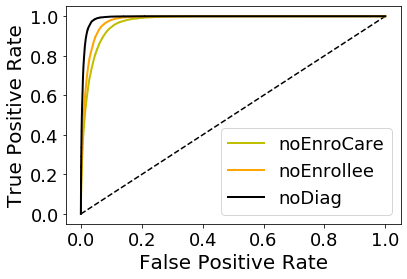

In [52]:
plot_roc_curves([no2, noenro,  nodiag ],['y','orange','black'],['noEnroCare','noEnrollee','noDiag'])

In [55]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2,random_state=2)


# upsampling training data only

In [62]:
tmodels = []
tscores = []
for d in [1,3,5,10]:
    model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=10, boosting_type='gbdt',
               class_weight={1: 100}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=d,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=300, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

    model.fit(Xt.values,yt.values)
    tests = evaluation(ytest.values,Xtest.values,model)
    tmodels.append(model)
    tscores.append(tests)


f1_socre: 0.311
precision: 0.186
recall/sensitivity(true positive rate): 0.957
false positive rate (FPR): 0.184
spcificity(true negative rate): 0.816
ROC_AUC_score: 0.887
f1_socre: 0.325
precision: 0.196
recall/sensitivity(true positive rate): 0.951
false positive rate (FPR): 0.171
spcificity(true negative rate): 0.829
ROC_AUC_score: 0.890
f1_socre: 0.332
precision: 0.201
recall/sensitivity(true positive rate): 0.953
false positive rate (FPR): 0.166
spcificity(true negative rate): 0.834
ROC_AUC_score: 0.893
f1_socre: 0.336
precision: 0.204
recall/sensitivity(true positive rate): 0.950
false positive rate (FPR): 0.162
spcificity(true negative rate): 0.838
ROC_AUC_score: 0.894


In [ ]:
feature_importance(model6,Xtrain.columns)
no2 = roc_curve(ytest,model6.predict_proba(Xtest.values)[:,1])
pickle.dump(model6,open("Models/lightgbm/lgb_upsampleTrainOnly.dat", "wb"))

In [64]:

for d in [10,30,50,100]:
    model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=3, boosting_type='gbdt',
               class_weight={1: d}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=300, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

    model.fit(Xt.values,yt.values)
    tests = evaluation(ytest.values,Xtest.values,model)
    tmodels.append(model)
    tscores.append(tests)

f1_socre: 0.378
precision: 0.237
recall/sensitivity(true positive rate): 0.940
false positive rate (FPR): 0.133
spcificity(true negative rate): 0.867
ROC_AUC_score: 0.904
f1_socre: 0.336
precision: 0.204
recall/sensitivity(true positive rate): 0.957
false positive rate (FPR): 0.164
spcificity(true negative rate): 0.836
ROC_AUC_score: 0.897
f1_socre: 0.323
precision: 0.194
recall/sensitivity(true positive rate): 0.957
false positive rate (FPR): 0.174
spcificity(true negative rate): 0.826
ROC_AUC_score: 0.891
f1_socre: 0.308
precision: 0.184
recall/sensitivity(true positive rate): 0.959
false positive rate (FPR): 0.187
spcificity(true negative rate): 0.813
ROC_AUC_score: 0.886


In [65]:
for d in [200,300,400]:
    model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=3, boosting_type='gbdt',
               class_weight={1: d}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=300, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

    model.fit(Xt.values,yt.values)
    tests = evaluation(ytest.values,Xtest.values,model)
    tmodels.append(model)
    tscores.append(tests)

f1_socre: 0.295
precision: 0.174
recall/sensitivity(true positive rate): 0.963
false positive rate (FPR): 0.200
spcificity(true negative rate): 0.800
ROC_AUC_score: 0.882
f1_socre: 0.285
precision: 0.167
recall/sensitivity(true positive rate): 0.964
false positive rate (FPR): 0.210
spcificity(true negative rate): 0.790
ROC_AUC_score: 0.877
f1_socre: 0.283
precision: 0.166
recall/sensitivity(true positive rate): 0.963
false positive rate (FPR): 0.212
spcificity(true negative rate): 0.788
ROC_AUC_score: 0.875


In [66]:
for d in [150,200]:
    model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=3, boosting_type='gbdt',
               class_weight={1: d}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=300, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

    model.fit(Xt.values,yt.values)
    tests = evaluation(ytest.values,Xtest.values,model)
    tmodels.append(model)
    tscores.append(tests)

f1_socre: 0.299
precision: 0.177
recall/sensitivity(true positive rate): 0.960
false positive rate (FPR): 0.195
spcificity(true negative rate): 0.805
ROC_AUC_score: 0.883
f1_socre: 0.296
precision: 0.175
recall/sensitivity(true positive rate): 0.964
false positive rate (FPR): 0.199
spcificity(true negative rate): 0.801
ROC_AUC_score: 0.883


In [67]:
for d in [100, 200, 400,600,1000]:
    model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=3, boosting_type='gbdt',
               class_weight={1: 200}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=d, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

    model.fit(Xt.values,yt.values)
    tests = evaluation(ytest.values,Xtest.values,model)
    tmodels.append(model)
    tscores.append(tests)

f1_socre: 0.174
precision: 0.096
recall/sensitivity(true positive rate): 0.985
false positive rate (FPR): 0.408
spcificity(true negative rate): 0.592
ROC_AUC_score: 0.789
f1_socre: 0.239
precision: 0.136
recall/sensitivity(true positive rate): 0.975
false positive rate (FPR): 0.270
spcificity(true negative rate): 0.730
ROC_AUC_score: 0.852
f1_socre: 0.342
precision: 0.209
recall/sensitivity(true positive rate): 0.953
false positive rate (FPR): 0.158
spcificity(true negative rate): 0.842
ROC_AUC_score: 0.897
f1_socre: 0.416
precision: 0.268
recall/sensitivity(true positive rate): 0.931
false positive rate (FPR): 0.111
spcificity(true negative rate): 0.889
ROC_AUC_score: 0.910
f1_socre: 0.488
precision: 0.334
recall/sensitivity(true positive rate): 0.910
false positive rate (FPR): 0.080
spcificity(true negative rate): 0.920
ROC_AUC_score: 0.915


In [68]:
for d in [100, 200, 400,600,1000]:
    model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=3, boosting_type='gbdt',
               class_weight={1: 200}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=d, n_jobs=4, num_leaves=100, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

    model.fit(Xt.values,yt.values)
    tests = evaluation(ytest.values,Xtest.values,model)
    tmodels.append(model)
    tscores.append(tests)

f1_socre: 0.126
precision: 0.068
recall/sensitivity(true positive rate): 0.995
false positive rate (FPR): 0.602
spcificity(true negative rate): 0.398
ROC_AUC_score: 0.697
f1_socre: 0.151
precision: 0.082
recall/sensitivity(true positive rate): 0.990
false positive rate (FPR): 0.487
spcificity(true negative rate): 0.513
ROC_AUC_score: 0.752
f1_socre: 0.198
precision: 0.110
recall/sensitivity(true positive rate): 0.981
false positive rate (FPR): 0.347
spcificity(true negative rate): 0.653
ROC_AUC_score: 0.817
f1_socre: 0.240
precision: 0.137
recall/sensitivity(true positive rate): 0.971
false positive rate (FPR): 0.267
spcificity(true negative rate): 0.733
ROC_AUC_score: 0.852
f1_socre: 0.323
precision: 0.195
recall/sensitivity(true positive rate): 0.953
false positive rate (FPR): 0.173
spcificity(true negative rate): 0.827
ROC_AUC_score: 0.890


In [69]:
for d in [5000,10000,50000,100000]:
    model = LGBMClassifier(bagging_fraction=0.1, bagging_freq=3, boosting_type='gbdt',
               class_weight={1: 200}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=1, min_child_weight=1, min_split_gain=0.0,
               n_estimators=d, n_jobs=4, num_leaves=100, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=d, subsample_freq=0)

    model.fit(Xt.values,yt.values)
    tests = evaluation(ytest.values,Xtest.values,model)
    tmodels.append(model)
    tscores.append(tests)

f1_socre: 0.666
precision: 0.547
recall/sensitivity(true positive rate): 0.851
false positive rate (FPR): 0.031
spcificity(true negative rate): 0.969
ROC_AUC_score: 0.910
f1_socre: 0.719
precision: 0.644
recall/sensitivity(true positive rate): 0.812
false positive rate (FPR): 0.020
spcificity(true negative rate): 0.980
ROC_AUC_score: 0.896


KeyboardInterrupt: 